# Analysis of Retention Data

### Imports and Load Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [55]:
df = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/Retention Data V1 - Raw.csv')
df.columns

Index(['id', 'customer_id', 'is_ftd', 'is_limited', 'dob', 'age',
       'coupon_designation', 'created_est', 'sign_up_time', 'total_amount',
       'contest_count', 'average_entry_amount', 'average_nr_of_picks', 'GGR',
       'deposit_amount', 'withdrawal_amount', 'net_cash', 'First SP Result',
       'Most Frequent State', 'First deposit amount', 'First Deposit Date'],
      dtype='object')

## Cleaning Data

In [56]:
df['coupon_designation'] = df['coupon_designation'].replace('influencer', 'Influencer')

df['created_est'] = pd.to_datetime(df['created_est'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
df['First Deposit Date'] = pd.to_datetime(df['First Deposit Date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

## Analysis of Overall Customer Basis

### Proportion of Customers that are ftd

In [5]:
ftd_counts = df['is_ftd'].value_counts()
ftd_counts

True    73470
Name: is_ftd, dtype: int64

We see that all customers are ftd. This shows that once on the platform, all customers make a deposit. 

In [6]:
coupon_counts = df['coupon_designation'].value_counts()
coupon_counts

referral        47109
Influencer      10429
Paid Digital     6554
Facebook         3923
Programmatic     2072
Apple            1414
Affiliate        1187
Offline           399
TikTok            383
Name: coupon_designation, dtype: int64

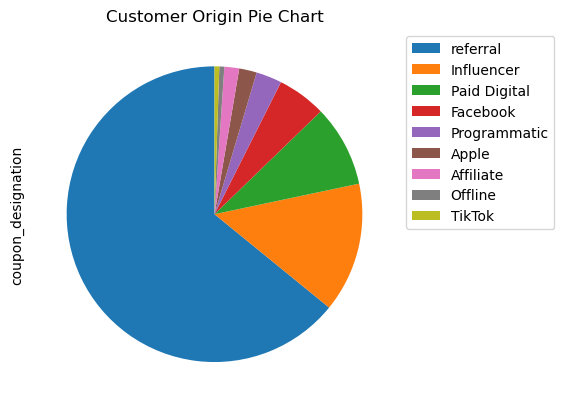

In [7]:
coupon_counts.plot(kind='pie', labels = None, startangle=90, legend =True)
plt.legend(labels = coupon_counts.index, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Customer Origin Pie Chart')
plt.show()

Given all the customers become ftd, it is interesting to see where our customers come from. We see that referral is by far the largest segment and so marketing strategies in this area appear to be working well. However, TikTok brings in the least customers which is surprising given how big a platform it is - especially compared with Facebook. It will be interesting to see the age demographic of our users as, from personal experience in the UK, TikTok is predominantly used by the younger generations, with Facebook reserved for older people. This also highlights that maybe a stronger emphasis may need to be placed on bringing in customers from TikTok.  

In [8]:
df['age'].describe()

count    73470.000000
mean        30.379134
std         10.086923
min         18.000000
25%         23.000000
50%         28.000000
75%         35.000000
max         94.000000
Name: age, dtype: float64

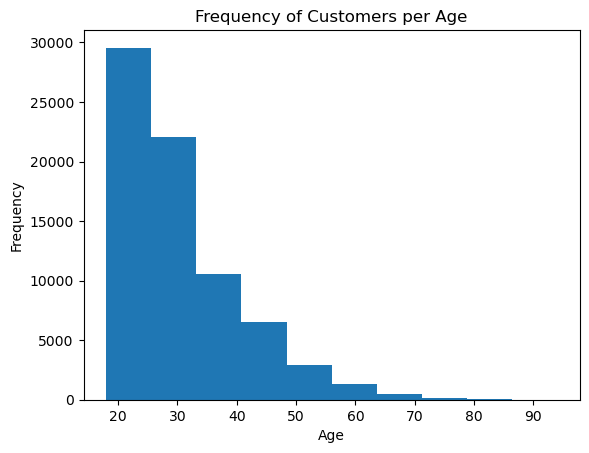

In [9]:
df['age'].plot(kind='hist')
plt.title("Frequency of Customers per Age")
plt.xlabel("Age")
plt.show()

This is not what I was expecting. This shows the demographic of our users is young (early 20s). Perhaps an analysis of the average age per coupon designation will yield an insight. 

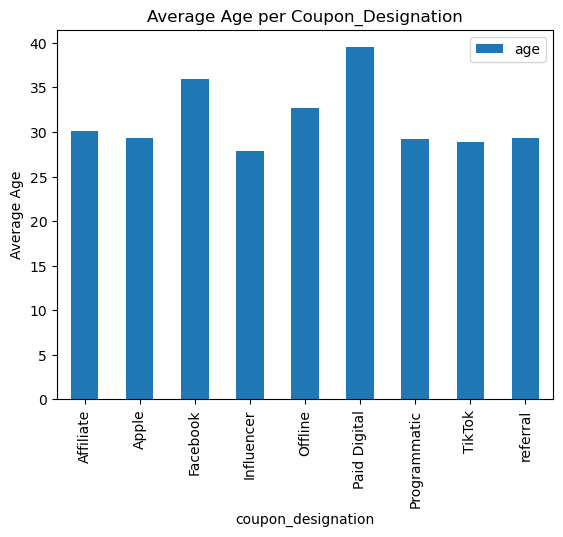

In [10]:
df[['coupon_designation','age']].groupby('coupon_designation').mean().plot(kind='bar')
plt.title("Average Age per Coupon_Designation")
plt.ylabel("Average Age")
plt.show()

This would make sense. The largest proportion of coupon_designation (referral), has one of the lowest average ages. This graph also shows that the age of referral and TikTok (the smallest proportioin of coupon_designation) is roughly the same, highlighting a potentially yet untapped customer source.  

The analysis thus far has given me an understanding of our customer basis. We now move to analysing customer LTV and activity.

## Customer Activity

### Feature Engineering

To analyse LTV and activity, there are a couple of metrics that might be usfeful:

* Time Difference between when first deposit is made and when the account was created
* Want score for how good a customer is, so do net_cash / countest_count (i.e. how much money a customer makes per contest)

In [57]:
# find time difference (in hours)
df['time_diff'] = (df['First Deposit Date'] - df['created_est']).astype('timedelta64[h]')
# find score
df['user_score'] = (df['net_cash'] / df['contest_count']).replace(np.inf, np.nan).fillna(0)

### Analysis of Levels of Engagement

In [12]:
df['contest_count'].describe()

count    73470.000000
mean        41.675378
std        105.018961
min          0.000000
25%          6.000000
50%         14.000000
75%         35.000000
max       4152.000000
Name: contest_count, dtype: float64

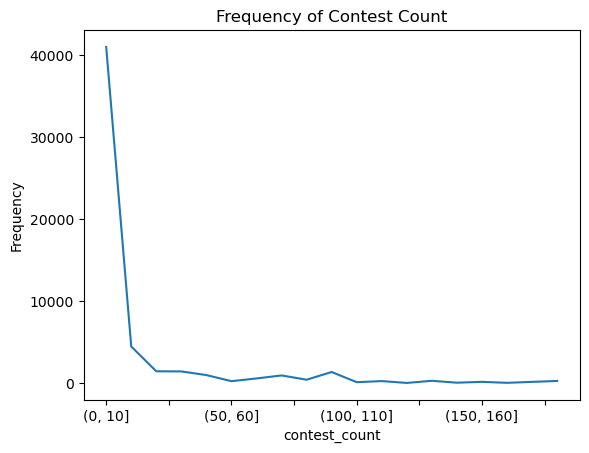

In [13]:
df['contest_count'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 200, 10))).sum().plot(kind = 'line')
plt.title("Frequency of Contest Count")
plt.ylabel("Frequency")
plt.show()

We see that our data is skewed to the right (mean > median) which would make sense as we will have a few customers who are very active with the platform. The median number of contests, 14, may be a useful benchmark for customer engagement. The line graph above shows that our users predominantly place less than 25 contests and so when analysing our customers, it makes sense to focus more here. 

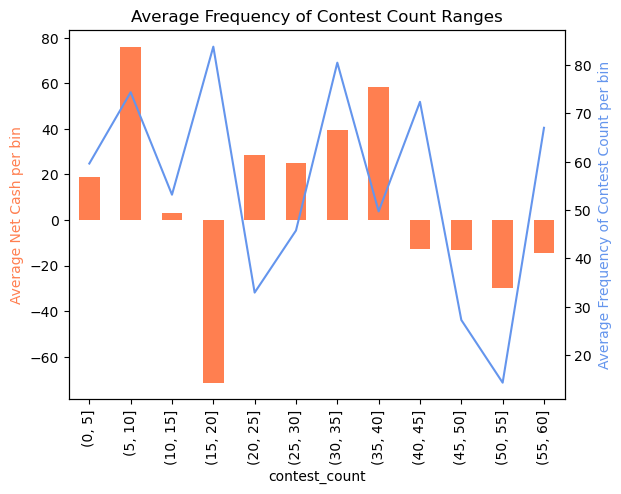

In [14]:
bar_data = df['net_cash'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 65, 5))).mean()
ax1 = bar_data.plot(kind='bar', color = 'coral', label='Net Cash')
ax1.set_ylabel('Average Net Cash per bin', color = 'coral')

ax2 = ax1.twinx()

line_data = df['contest_count'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 65, 5))).mean()
line_data.plot(kind='line', ax=ax2, color = 'cornflowerblue', label='Contest Count')
ax2.set_ylabel('Average Frequency of Contest Count per bin', color = 'cornflowerblue')

plt.title("Average Frequency of Contest Count Ranges")
plt.show()

This graph gives us an idea of the most profitable users (for the company). As expected, we see that as the number of contests increases (i.e. the user becomes more involved with the platform), the user wins more as shown by the negative bar graphs in the contest_counts range [40-60]. These customers are likely very involved with the platform. 

Interestingly however, we see that for contest_counts between [5-10], the frequency of these contests increases and so does the net cash so we can identify these customers as our most profitable. These users could potentially be either new or casual users who aren't as skilled as more regular ones. 

That said, with [15-20] contests, we also have a spike in frequency but a dramatic loss of money. This could imply that customers with around [15-20] picks are adept in making good picks which would correspond to regular but not highly active users. 

Between [20-40] is pretty interesting too because as the contest_counts increase (i.e. higher customer engagment), they seem to be getting worse. A thought I had on this was how often do customers receive promotion picks? Could this range be customers moving from solely using free picks to actually spending their own money? Would be interesting to explore this further. 

#### First Deposit Amount (FDA)

Below analyses the FDA's impact on user engagement and profitability.

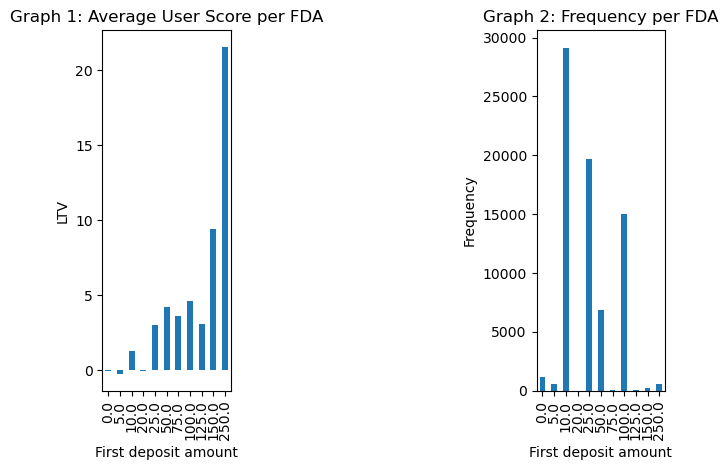

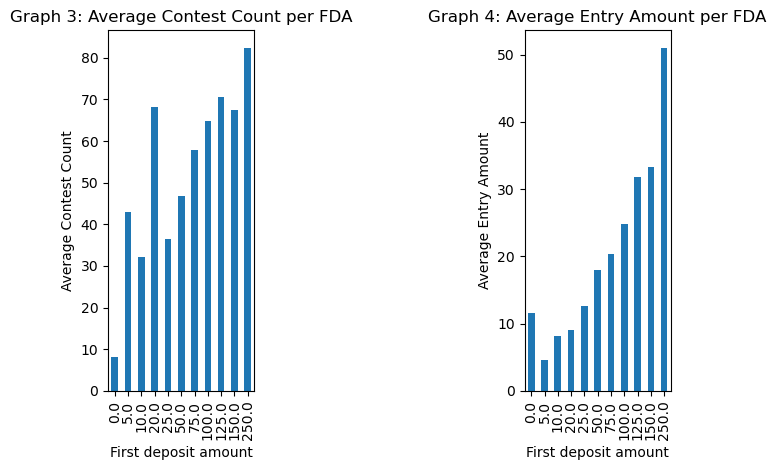

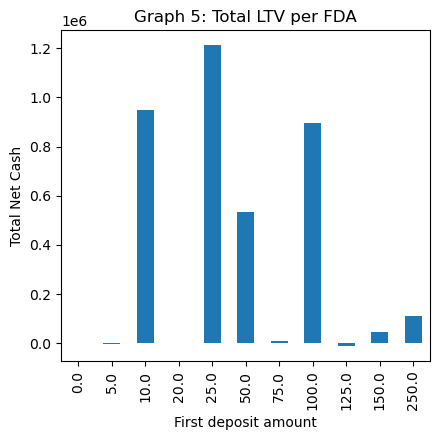

In [15]:
plt.subplot(1,3, 1)
df.groupby('First deposit amount').user_score.mean().plot(kind = 'bar')
plt.title("Graph 1: Average User Score per FDA")
plt.ylabel("LTV")

plt.subplot(1,3,3)
df['First deposit amount'].value_counts().sort_index().plot(kind='bar')
plt.title("Graph 2: Frequency per FDA")
plt.ylabel("Frequency")
plt.xlabel("First deposit amount")
plt.tight_layout()
plt.show()

plt.subplot(1,3,1)
df.groupby('First deposit amount').contest_count.mean().plot(kind = 'bar')
plt.title("Graph 3: Average Contest Count per FDA")
plt.ylabel("Average Contest Count")

plt.subplot(1,3,3)
df.groupby('First deposit amount').average_entry_amount.mean().plot(kind = 'bar')
plt.title("Graph 4: Average Entry Amount per FDA")
plt.ylabel("Average Entry Amount")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4.5,4.5))
df.groupby('First deposit amount').net_cash.sum().plot(kind = 'bar')
plt.title("Graph 5: Total LTV per FDA")
plt.ylabel("Total Net Cash")
plt.tight_layout()
plt.show()

In [17]:
df_ltv_fda = df.groupby('First deposit amount').user_score.mean()
print("Stat 1: ")
print("Percentage increase in user score from FDA of 10 to 25: ", (df_ltv_fda[25.0] / df_ltv_fda[10.0] - 1)* 100, "%")

df_net_cash_fda = df.groupby('First deposit amount').net_cash.sum()
print("\nStat 2: ")
print("Percentage increase in LTV from FDA of 10 to 25: ", (df_net_cash_fda[25.0] / df_net_cash_fda[10.0] - 1)* 100, "%")

Stat 1: 
Percentage increase in user score from FDA of 10 to 25:  138.72382608815687 %

Stat 2: 
Percentage increase in LTV from FDA of 10 to 25:  27.720260268110298 %


We see that the more a user first deposits, the higher their score whilst, unsurprisingly, the frequency of each first deposit amount decreases as the amount grows. We also see that as FDA increases so too does the number of contests and the entry amount of users. 

Upon inspection, we see that, overall, the most profitable set of users for the company is those first depositing $100$. These users have the third highest LTV, are the third most frequent, have a high number of contests and have the third highest score. These would imply that these users engage well with the platform (the high contest count) with an average entry amount for each pick (shown in Graph 4). These picks usually result in a net win for the company (high user score). Customers first depositing around $100$ are highly valuable. 

An interesting case is for $10 FDAs which are the most frequent. Their total LTV is the 2nd highest which would imply they are profitable for the company, however they have a relatively low user score, suggesting per contest they're not overly profitable for the company. Looking at their contests and the amounts they enter, we see they place a low number of small picks which would suggest poor engagement with the platform. This would make sense as casual/unsure users would be less willing to deposit large amounts. These users are probably of high interest for the company. 

Furthermore, in Graph 1, we first notice the high score for $150 , $250. Whilst the frequency of users depositing this amount is low (as expected), they have one of the highest contest counts implying users in this bracket often engage with the platform and from Graph 4, we see they also place the highest amount on their picks. Despite the high engagement of these users, their low frequency ultimately means their overall impact on the total LTV is limited (as shown in Graph 5). 

Users with a $10$ FDA are of the most interest as pushing this deposit to just $25 over doubles their score (Stat 1) and increases the total LTV (profitability) by over 25% (Stat 2). Emphasis on pushing this could be highly profitable for the company.


Continuing with the idea of initial data from the user, it could be interesting to see how the LTV is affected by the result of the first SP. 

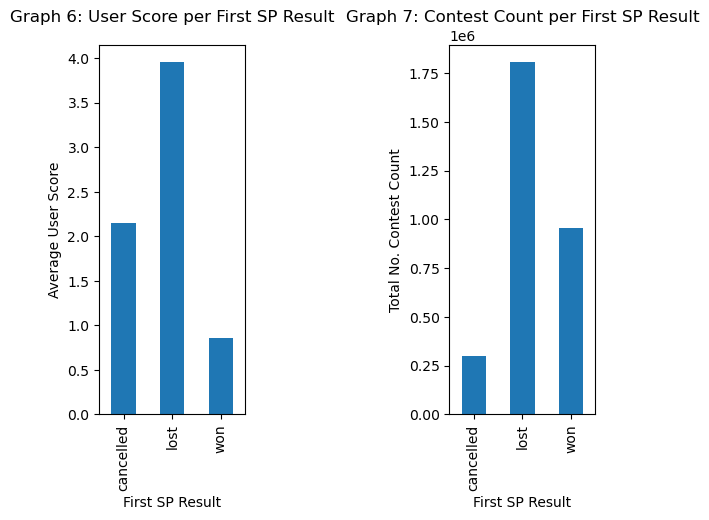

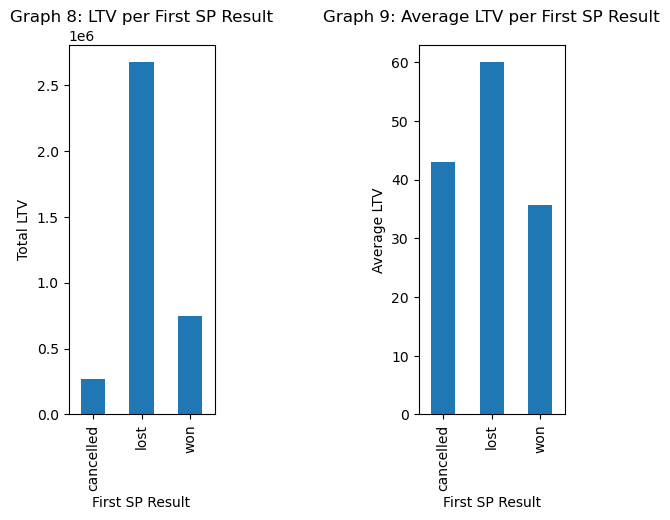

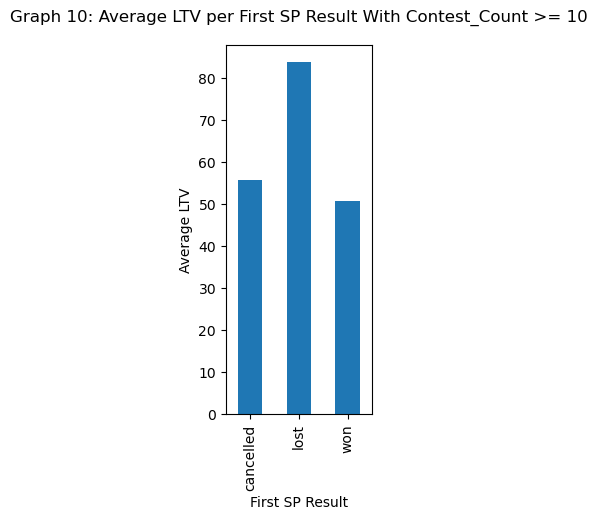

In [74]:
plt.subplot(1,3,1)
df.groupby('First SP Result').user_score.mean().plot(kind = 'bar')
plt.ylabel("Average User Score")
plt.title("Graph 6: User Score per First SP Result", y=1.04)

plt.subplot(1,3,3)
df.groupby('First SP Result').contest_count.sum().plot(kind = 'bar')
plt.ylabel("Total No. Contest Count")
plt.title("Graph 7: Contest Count per First SP Result", y=1.04)
plt.show()

plt.subplot(1,3,1)
df.groupby('First SP Result').net_cash.sum().plot(kind = 'bar')
plt.ylabel("Total LTV")
plt.title("Graph 8: LTV per First SP Result", y=1.04)

plt.subplot(1,3,3)
df.groupby('First SP Result').net_cash.mean().plot(kind = 'bar')
plt.ylabel("Average LTV")
plt.title("Graph 9: Average LTV per First SP Result", y=1.04)
plt.show()


plt.subplot(1,3,3)
df_lim_cont = df[df['contest_count'] >= 10]

df_lim_cont.groupby('First SP Result').net_cash.mean().plot(kind = 'bar')
plt.ylabel("Average LTV")
plt.title("Graph 10: Average LTV per First SP Result With Contest_Count >= 10", y=1.04)
plt.show()

In [20]:
df_ltv_first_sp = df.groupby('First SP Result').user_score.mean()
print("Stat 3:")
print("Proportion increase in user score from losing vs winning first SP: ", df_ltv_first_sp['lost']/df_ltv_first_sp['won'])

df_contest_count_first_sp = df.groupby('First SP Result').contest_count.sum()
print("\nStat 4:")
print("Percentage increase in contest count from losing vs winning first SP: ", (df_contest_count_first_sp['lost']/df_contest_count_first_sp['won'] - 1)*100, "%")

df_net_cash_first_sp = df.groupby('First SP Result').net_cash.sum()
print("\nStat 5:")
print("Proportion increase in total LTV from losing vs winning first SP: ", df_net_cash_first_sp['lost']/df_net_cash_first_sp['won'] )

Stat 3:
Proportion increase in user score from losing vs winning first SP:  4.58148348727249

Stat 4:
Percentage increase in contest count from losing vs winning first SP:  88.27491897857196 %

Stat 5:
Proportion increase in total LTV from losing vs winning first SP:  3.557552309870131


This is particularly interesting. From Graph 6 we see that winning the first SP results in the lowest user score whilst losing leads to the highest (4.5 times higher than winning). This would make sense as an informed, skilled user would have a higher chance of winning in their first SP and would only improve with time leading to a lower score. Perhaps counterintuitively however,losing results in the highest total number of contests (88% higher than winning) and by far the highest net cash (over 3.5 times that of winning). This could be because users keep searching for a big win that might never happen or winning users are more selective with their picks. That said, both engage fully with the platform, shown by the high contest counts in Graph 7. 

It is also worth noting that although a cancelled first SP results in a good score, it's total contest count is signficantly lower than the other two outcomes and it has the smallest total LTV. One reason for this could be a user who is unsure initially might cancel and so has a lower chance of continuing into the future. Another could be, if the pick was cancelled by the platform, the user could become disinterested and leave the site. 

In conclusion, we can see that the company's most profitable users lose their first SP and that user's who's SP was cancelled are most vulnerable. 

### Analysis of Time Between Account Creation and First SP

In [58]:
print("Range of LTV: ", df['net_cash'].max() - df['net_cash'].min())

Range of LTV:  48785.0


We have a very large range of LTV so will only take values +- 1 standard deviation of the mean.

In [123]:
mean = df['net_cash'].mean()
std = df['net_cash'].std()

df_limited = df[(df['net_cash'] < mean + std) & (df['net_cash'] > mean - std)]

mean_limited = df_limited['net_cash'].mean()
std_limited = df_limited['net_cash'].std()

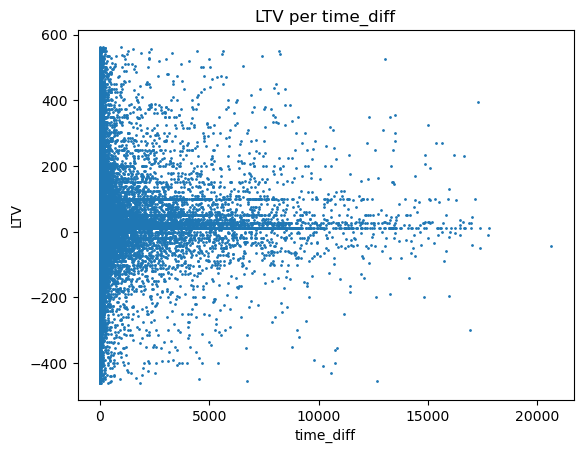

In [167]:
df_limited.plot.scatter(x = "time_diff", y = "net_cash", s=1)
plt.title("LTV per time_diff")
plt.ylabel("LTV")
plt.show()

In [173]:
from scipy.stats import kurtosis, skew

skewness = skew(df_limited['net_cash'])
kurt = kurtosis(df_limited['net_cash'])

print("Skewness: ", skewness)
print("Kurtosis: ", kurt)

Skewness:  0.4965747059333161
Kurtosis:  4.340944319898132


We see that the data roughly follows a gaussian distribution centered just positive of 0 LTV. We see that the LTV has a skewness of around 0.5 and so we know our data is approximately symmetrical although with a positive bias and a kurtosis of 4.3 indicates our data has heavy tails.

Perhaps it will be more fruitful to explore the time difference with respect to some more categories.

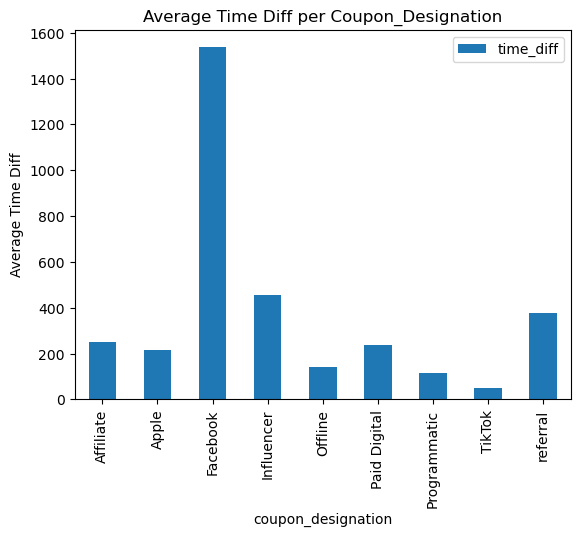

In [132]:
df[['coupon_designation','time_diff']].groupby('coupon_designation').mean().plot(kind='bar')
plt.title("Average Time Diff per Coupon_Designation")
plt.ylabel("Average Time Diff")
plt.show()

In [154]:
df_av_time_coupon = df[['coupon_designation','time_diff']].groupby('coupon_designation').mean()
print("Stat 6: ")
print("Proportion Facebook time is larger than Influencer: ", df_av_time_coupon['time_diff']['Facebook']/df_av_time_coupon['time_diff']['Influencer'])

Stat 6: 
Proportion Facebook time is larger than Influencer:  3.3674389850890143


This is an interesting and unexpected graph. We see that users from Facebook, the 4th largest coupon designation, take by far the longest time before their first play (over 3x 2nd longest coupon designation). A reason could be the fact this is a social media platform, so people use the coupon and then return to the app. It would be interesting to see the contest counts for these platforms. 

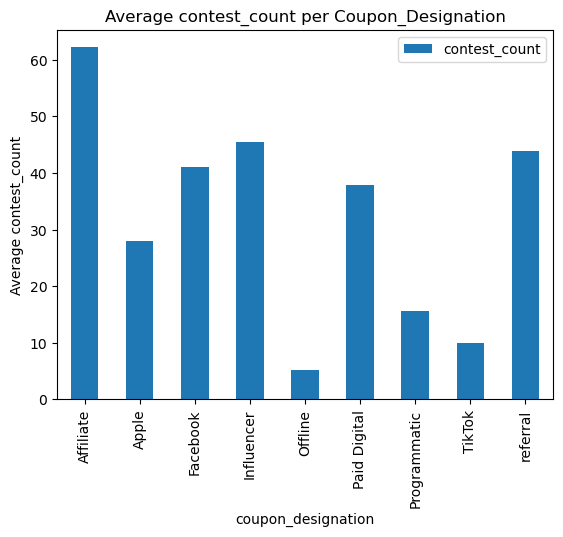

In [153]:
df[['coupon_designation','contest_count']].groupby('coupon_designation').mean().plot(kind='bar')
plt.title("Average contest_count per Coupon_Designation")
plt.ylabel("Average contest_count")
plt.show()

In [159]:
print("Stat 7: ")
print("Number of times smaller Offline contest count is than average: ", df['contest_count'].mean() / df[['coupon_designation','contest_count']].groupby('coupon_designation').mean()['contest_count']['Offline'])


Stat 7: 
Number of times smaller Offline contest count is than average:  8.147454303644942


Interestingly, we see that this doesn't really affect the user's engagement with the platform, with Facebook having the 4th highest contest count. What is surprising though is just how low we find Offline (being over 8 times less than the average contest count). This shows us that these users quickly disengage with the platform, perhaps an area to look into.

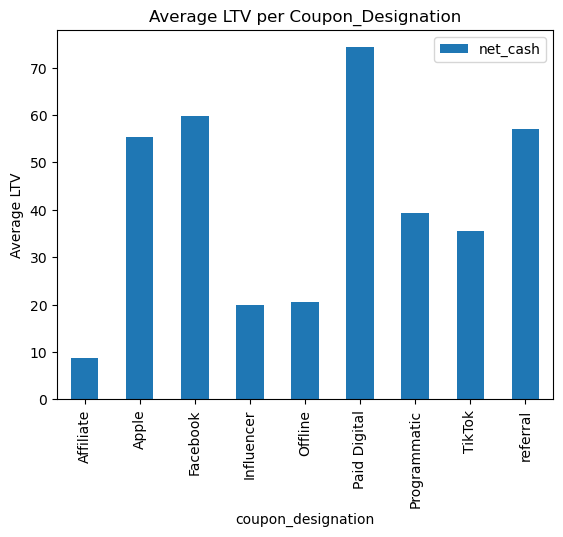

In [155]:
df[['coupon_designation','net_cash']].groupby('coupon_designation').mean().plot(kind='bar')
plt.title("Average LTV per Coupon_Designation")
plt.ylabel("Average LTV")
plt.show()

Here we see that Offline leads to a low LTV which makes sense given the low number of contest counts. We also see a low LTV for Influencers too; a reason for this could be that these users potentially follow trends more than other users and so once no longer in fashion, they stop using the app, just a thought. 

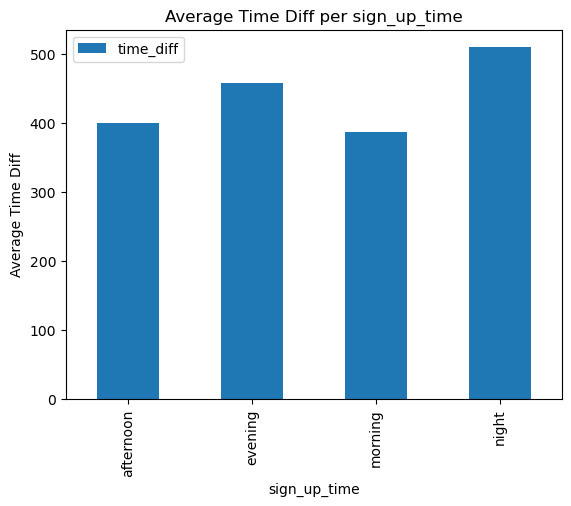

In [174]:
df[['sign_up_time','time_diff']].groupby('sign_up_time').mean().plot(kind='bar')
plt.title("Average Time Diff per sign_up_time")
plt.ylabel("Average Time Diff")
plt.show()

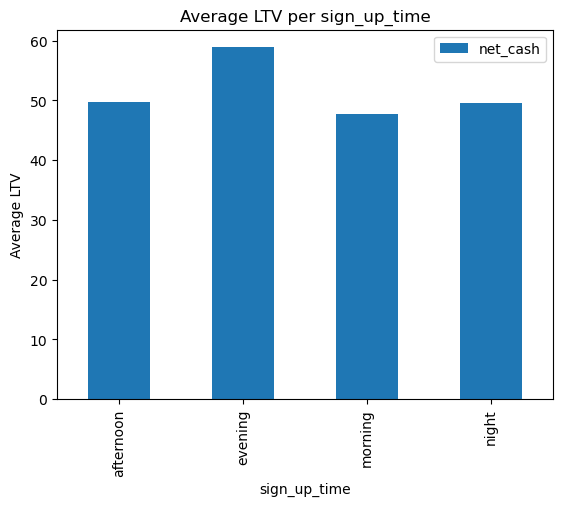

In [176]:
df[['sign_up_time','net_cash']].groupby('sign_up_time').mean().plot(kind='bar')
plt.title("Average LTV per sign_up_time")
plt.ylabel("Average LTV")
plt.show()